# Exective summary of Work Package 2

## Objectives

This work package aims at developing a data-driven fault detection algorithm for the motors in the robot. The algorithm should be able to accurately detect faults under different working conditions of the robot, and to display the results in the GUI developed in WP1.

## Tasks

- Task 1: Training data generation: Generate training data for your model, considering different working conditions of the robot.
- Task 2: Model development.
  - Data cleaning, preprocessing
  - Investigate different possible model and train the final model
- Task 3: GUI design and implementation.
- Task 4: Data challenge: Each group will generate a separate dataset, which will be used to construct a final evaluation dataset for the other groups. The performance of your model will be evaluated through this testing dataset.

## Deliverables

- A Jupyter notebook reporting the model development process, including but not limited to:
  - Data cleaning, preprocessing
  - The models you tried and their performance evaluation through cross validation
  - The final model with best performance
- A demo software for condition-monitoring and fault detection:
  - The software should be able to read the data from the robot and display the results in the GUI.
  - The software should be able to detect faults in the robot and display the results in the GUI.
  - Record a video with the robot to demonstrate the functionality of your software.


# Working plan for today's TD

Today, we mainly work on task 2. More specifically, we will work on the following:
1. Explore the data we collected last week, including:
    - Data visualization to explore the patterns of the data
    - Use Principle Component Analysis (PCA) or t-SNE to visualize the data, in order to have a first flavor about the difficulty of the problem 
    - Explore if we have a significant difference between different sequences through visualization and clustering
2. Data cleaning and preprocessing
    - Missing values and outlier handling
    - Feature engineering
3. Apply local outlier analysis model.
4. Apply a simple logistic regression model as a benchmark model for the classification task.

Before starting, please:
- Fetch the most up-to-date version of the github repository.
- Create a new branch called "WP2_TD_Lect_5_YourName", based on the branch "zhiguo_dev" and switch to it.
- Copy the notebook WP2_DATA-DRIVEN FAULT DETECTION/support/WP2_TD_Lect_5 to WP2_DATA-DRIVEN FAULT DETECTION/TD_5/, and rename it to TD_Lect_5_YourName.ipynb
- After finishing this task, push your changes to your github repository.
- Submit a pull request to the "zhiguo_dev" branch.

# Exercise 1 Data exploration

## Task 1: Read the data from the different csv files and store it in a dataframe. 

First, we read all the data from the different sub-folders and store it in a dataframe. In utility.py, there are some supporting functions for this task:
- It reads all the csv file and create a sigle dataframe.
- It rename the features as "data_motor_X+feature names".
- It adds a column "label" to the dataframe, where label = 0 means normal data, while label = 1 means abnormal data.
- It adds a column "seq_idx" to the dataframe, indicating the data are from which sequence. One sequence is generated by one person.

Below, you can find a sample code of reading the data. You need to replace the path with your own path.


```python
from utility import read_data

# Root path to the folder containing the CSV files
path_normal = r'../Data collection_20231109/Normal sequence'
path_failure = r'../Data collection_20231109/Failure sequence'
df = read_data(path_normal, path_failure)
```

**Your task:**

Use the code to create the data frame, and print its column names, and visulize in a data explorer.
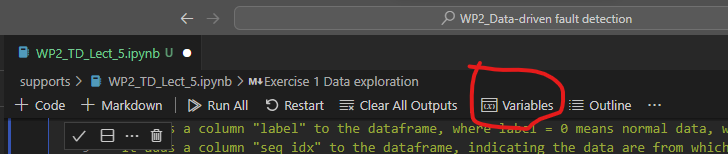

# Task 1: Dataframe creation

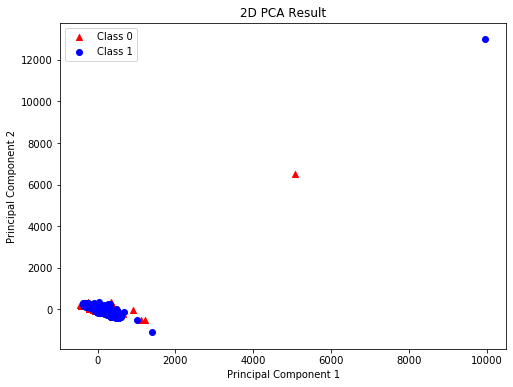

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


def combine_csv(folder_path, seq_idx, label):
    """
    Combine all CSV files in a folder into a single DataFrame.
    :param folder_path: Path to the folder containing the CSV files
    :param seq_idx: Sequence index
    :param label: Label of the sequence (Normal - 0, Abnormal - 1)
    :return: A single DataFrame containing all the data from the CSV files
    """

    # Get a list of all CSV files in the folder
    csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

    # Create an empty DataFrame to store the combined data
    combined_df = pd.DataFrame()

    # Iterate over the CSV files in the folder
    for file in csv_files:
        # Construct the full path to each CSV file
        file_path = os.path.join(folder_path, file)

        # Read each CSV file into a DataFrame
        df = pd.read_csv(file_path)
        # Drop the time. Will add later.
        df = df.drop(labels=df.columns[0], axis=1)

        # Extract the file name (excluding the extension) to use as a prefix
        file_name = os.path.splitext(file)[0]

        # Add a prefix to each column based on the file name
        df = df.add_prefix(f'{file_name}_')

        # Concatenate the current DataFrame with the combined DataFrame
        combined_df = pd.concat([combined_df, df], axis=1)

    df = pd.read_csv(file_path)
    combined_df = pd.concat([df['time'], combined_df], axis=1)
    combined_df.loc[:, 'sequence_idx'] = seq_idx
    combined_df.loc[:, 'label'] = label

    return combined_df


def combine_all_csv(path, label, seq_idx=0):
    """
    Combine all CSV files in a folder into a single DataFrame.
    :param path: Path to the folder containing the CSV files
    :param label: Label of the sequence (Normal - 0, Abnormal - 1)
    :return: A single DataFrame containing all the data from the CSV files
    """
    # Get all directories in the given path
    folders = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
    df = pd.DataFrame()
    for folder in folders:
        folder_path = path+'\\'+folder
        tmp_df = combine_csv(folder_path, seq_idx, label)
        seq_idx += 1
        df = pd.concat([df, tmp_df])
        df = df.reset_index(drop=True)

    return  df


def read_data(path_normal, path_failure):
    df = pd.concat([combine_all_csv(path_normal, 0), combine_all_csv(path_failure, 1, seq_idx=4)]).reset_index(drop=True)

    return df


if __name__ == '__main__':
    # Folder containing the CSV files
    path_normal = r'C:\Users\User\Documents\GitHub\digital_twin_robot\course_project_DARR\WP2_Data-driven fault detection\Data collection_20231109\Normal sequence'
    path_failure = r'C:\Users\User\Documents\GitHub\digital_twin_robot\course_project_DARR\WP2_Data-driven fault detection\Data collection_20231109\Failure sequence'
    df = read_data(path_normal, path_failure)

    # Separate X,Y dataframes
    X = df.drop(['label', 'sequence_idx', 'time'], axis=1)
    y = df['label']
    
    # Normalization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # PCA (2-D)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], color='red', marker='^', label='Class 0')
    plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], color='blue', marker='o', label='Class 1')
    plt.title('2D PCA Result')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

## Task 2: Data visualization

Going through the different sub-tasks from below. Then, write a summary here about your major observations regarding the patterns in the original data. Below are a few hints for your to organize your summary:
- Do we have a lot noise in the features? Do we need to smooth the data?
- Do we need to scale the features?
- Do we have a lot of outliers? Do we need to remove them?
- Do we have a lot of missing values? Do we need to fill them?
- Do we have a lot of categorical features? Do we need to encode them?

**Submit your summary below:**

## Answer
Clusters are well organized, while there seems not to be much noise in the dataset. Outliers are not abundant although they deviate significantly from the clusters.

Due to the fact of data having different units, scaling could be of use in order to render them more suitable for visualization analysis and their being on a comparable level. Min-Max Scaling could be applied with scale deviating between 0 and 1 and all the values get proportionally transformed.

Outliers that are error points would be better to be removed, such as the two points on the top right corner of the scatter plot (1 for each class), whereas data points that do not deviate a lot from the data cluster are probably valid or even feasible points that are not prefered to be removed.

Based on the data collection algorithm, small leaps are observed between values that could be referred as missing values, but through the conducted time series analysis, it is not absurd and could be regarded as a normal phenomenon.

Categorical features should be encoded, due to their somehow large number, in order to ameliorate the performance of the model, the visualization and all the analysis and coding procedures.


### Sub-task 1: Visualize each sequence to explore its basic pattern. 

We would like to visually inspect the time series data. Use the following code to explore the data. 

Note: To use iterative plot, you need to install ipywidgets package: 

```python
pip install ipywidgets

In [11]:
pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interactive

# Create dropdown widgets for column selection and sequence_idx selection
column_dropdown = widgets.Dropdown(options=df.columns, description='Select Column:')
sequence_dropdown = widgets.Dropdown(options=df['sequence_idx'].unique(), description='Select sequence_idx:')

# Function to update the plot based on the selected column and sequence_idx
def update_plot(selected_column, selected_sequence_idx):
    filtered_df = df[df['sequence_idx'] == selected_sequence_idx]
    
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_df['time'], filtered_df[selected_column], marker='o')
    plt.xlabel('Time')
    plt.ylabel(selected_column)
    plt.title(f'Plot of {selected_column} for sequence_idx {selected_sequence_idx}')
    x_ticks_labels = [time[-8:] for time in filtered_df['time']]
    plt.xticks(filtered_df['time'][::10], x_ticks_labels[::10], rotation=45, ha='right')  # Display tickers with the last 8 characters    
    plt.grid(True)
    plt.show()

# Create an interactive plot using both dropdown widgets
interactive_plot = interactive(update_plot, selected_column=column_dropdown, selected_sequence_idx=sequence_dropdown)

# Display the interactive plot
interactive_plot


interactive(children=(Dropdown(description='Select Column:', options=('time', 'data_motor_1_position', 'data_m…

### Sub-task 2 Explore the distribution of each feature through histogram and box plot.

### Seaborn Visualization

In [8]:
pip install --upgrade seaborn


     -------------------------------------- 293.3/293.3 kB 9.1 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.10.0
    Uninstalling seaborn-0.10.0:
      Successfully uninstalled seaborn-0.10.0
Note: you may need to restart the kernel to use updated packages.


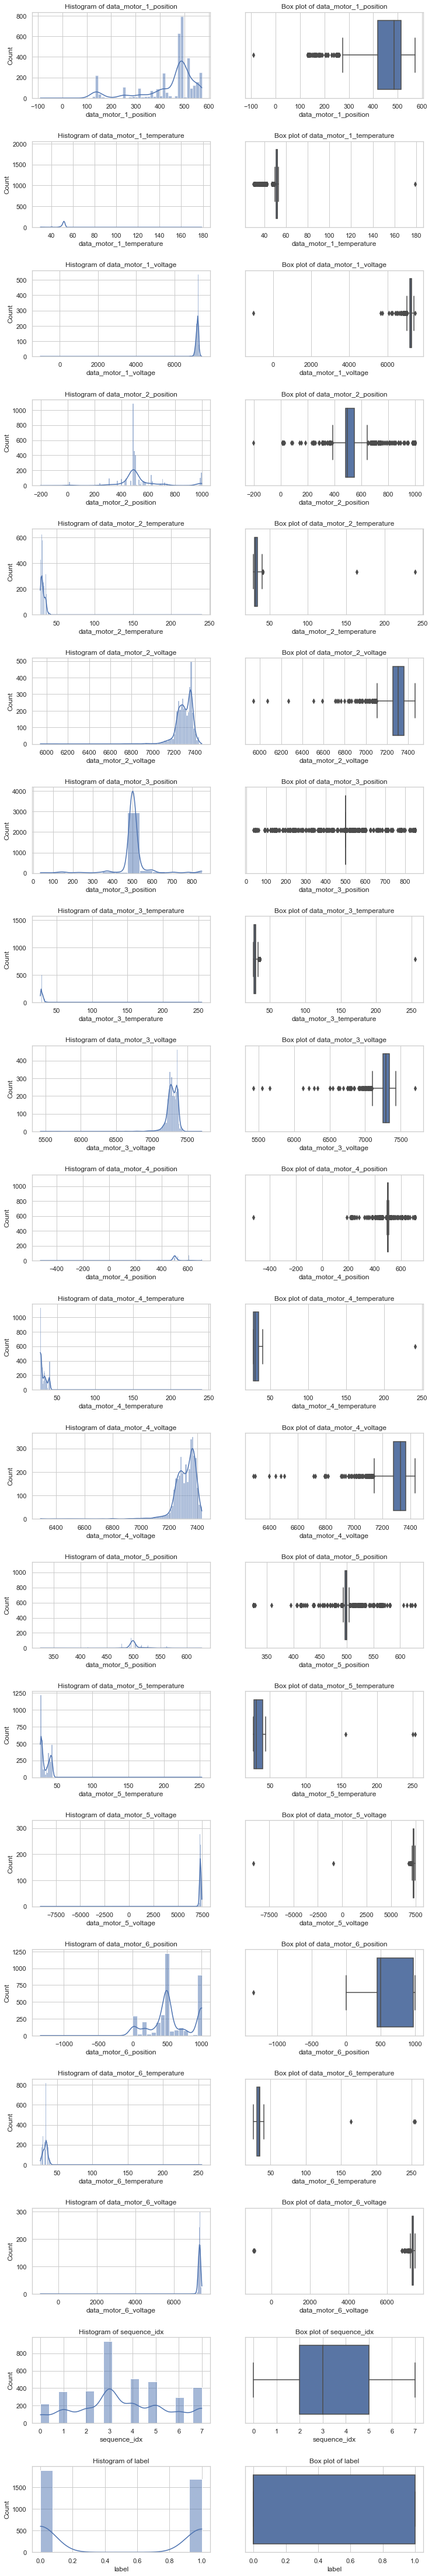

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn style
sns.set(style="whitegrid")

# List of numerical columns
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Plot features
num_features = len(numerical_columns)
fig, axes = plt.subplots(nrows=num_features, ncols=2, figsize=(12, 4 * num_features))
fig.subplots_adjust(hspace=0.5)

# Looping for histogram and box plots
for i, column in enumerate(numerical_columns):
    # Histogram
    sns.histplot(df[column], kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Histogram of {column}')
    
    # Box plot
    sns.boxplot(x=df[column], ax=axes[i, 1])
    axes[i, 1].set_title(f'Box plot of {column}')

# Display the plots
plt.show()


### Matplotlib Visualization

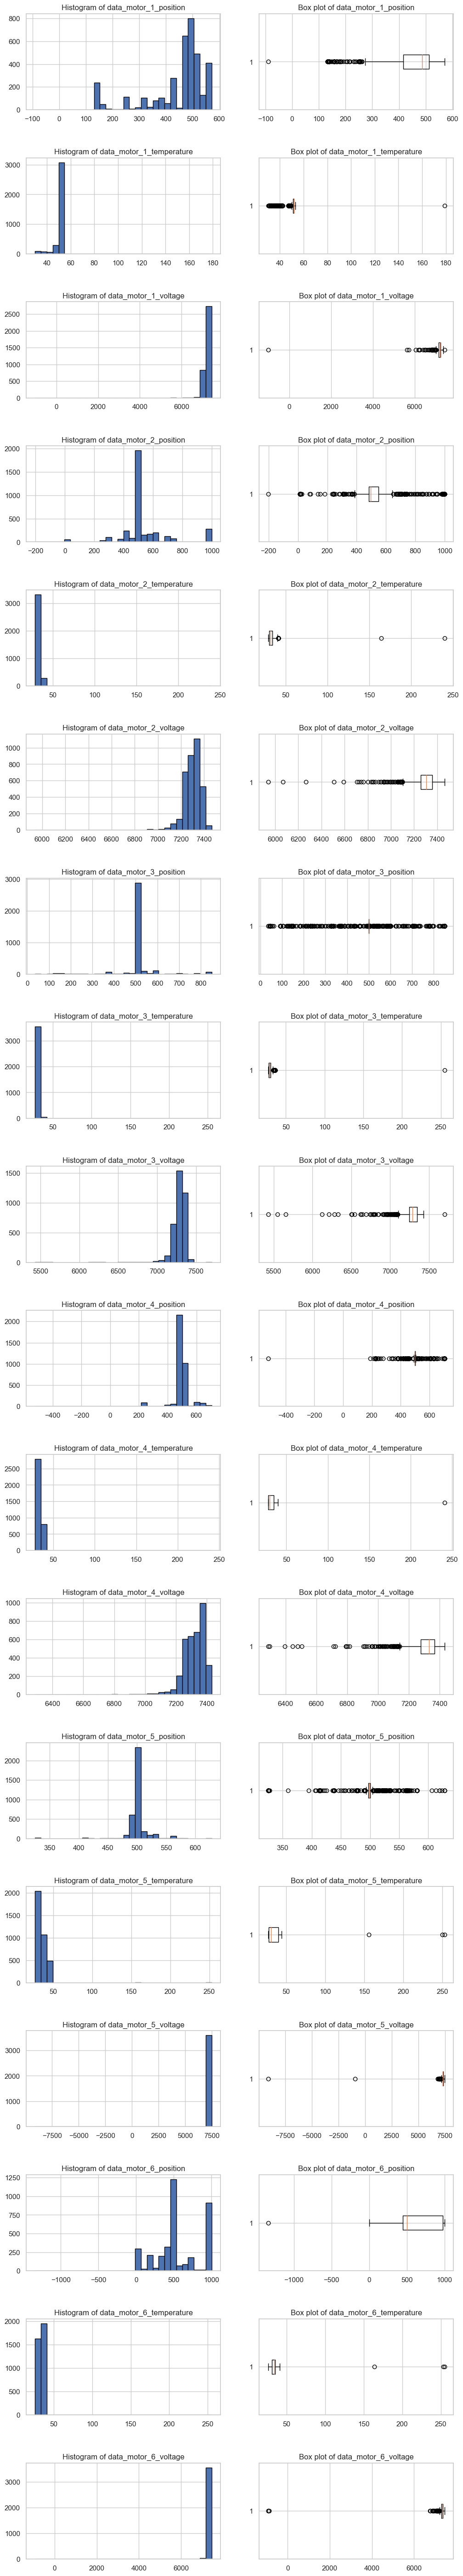

In [17]:
import matplotlib.pyplot as plt


# List of numerical columns excluding 'sequence_idx' and 'label'
numerical_columns = [col for col in df.select_dtypes(include=['float64', 'int64']).columns if col not in ['sequence_idx', 'label']]

# Plot features
num_features = len(numerical_columns)
fig, axes = plt.subplots(nrows=num_features, ncols=2, figsize=(12, 4 * num_features))
fig.subplots_adjust(hspace=0.5)

# Plot code
for i, column in enumerate(numerical_columns):
    # Histogram
    axes[i, 0].hist(df[column], bins=30, edgecolor='black')
    axes[i, 0].set_title(f'Histogram of {column}')
    
    # Box plot
    axes[i, 1].boxplot(df[column], vert=False)
    axes[i, 1].set_title(f'Box plot of {column}')

# Plots
plt.show()


### Sub-task 3 Use PCA to visulize the data in a 2-d plane.

Normally, before any further analysis, we try to plot all the features directly in a 2-d plane. This is because the 2-d plane is a very simple representation of the data and allows us to visually inspect the patterns of the data. A normal conclusion we can make is whether the data are linear seperable or not, i.e., if you can simply fit a straight line to seperate postitive and negative classes. However, if the data is high-dimensional, it is difficult to visualize it in a 2-d plane. In this case, we can use PCA to reduce the dimensionality of the data and then plot it in a 2-d plane.

Below is a code for performing PCA and plotting the data in a 2-d plane. What can you see from the results?

### Neither Standardized nor Normalized Data

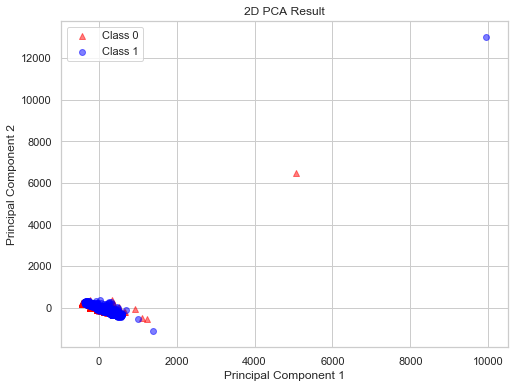

In [4]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Separate X,Y dataframes
X = df.drop(['label', 'sequence_idx', 'time'], axis=1)
y = df['label']

# PCA (2-D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], color='red', marker='^', alpha=.5, label='Class 0')
plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], color='blue', marker='o', alpha=.5, label='Class 1')
plt.title('2D PCA Result')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In the above analysis, we did not perform data normalization/standardization. Could you try to do that and see if the results change? You can use the follwing code for standardization:

```python
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
```

And this for normalization:

```python
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
```

### Standardized data

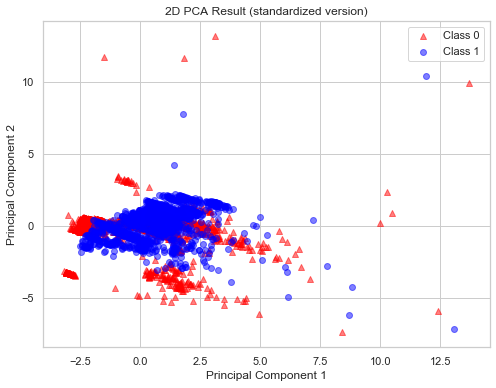

In [5]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Separate X,Y dataframes
X = df.drop(['label', 'sequence_idx', 'time'], axis=1)
y = df['label']

#Standardization
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X)

# PCA (2-D)
pca = PCA(n_components=2)
X_pca_st = pca.fit_transform(X_train)

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(X_pca_st[y == 0, 0], X_pca_st[y == 0, 1], color='red', marker='^', alpha=.5, label='Class 0')
plt.scatter(X_pca_st[y == 1, 0], X_pca_st[y == 1, 1], color='blue', marker='o', alpha=.5, label='Class 1')
plt.title('2D PCA Result (standardized version)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

### Normalized Data

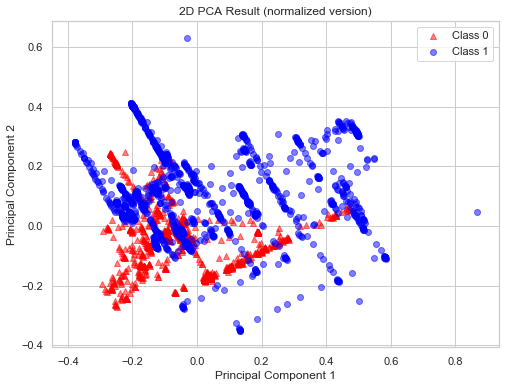

In [6]:
# Seperate X,Y dataframes
X = df.drop(['label', 'sequence_idx', 'time'], axis=1)
y = df['label']

#Normalization
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X)

# PCA (2-D)
pca = PCA(n_components=2)
X_pca_norm = pca.fit_transform(X_train)

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(X_pca_norm[y == 0, 0], X_pca_norm[y == 0, 1], color='red', marker='^', alpha=.5, label='Class 0')
plt.scatter(X_pca_norm[y == 1, 0], X_pca_norm[y == 1, 1], color='blue', marker='o', alpha=.5, label='Class 1')
plt.title('2D PCA Result (normalized version)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

### Standardized and Normalized Data

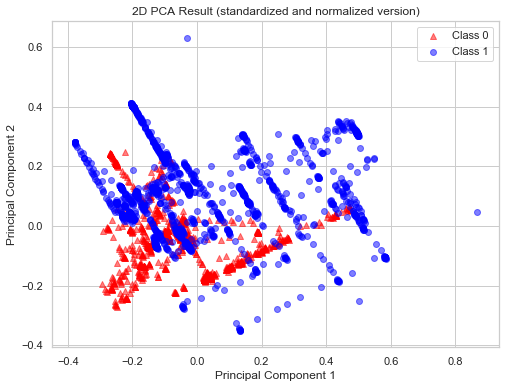

In [7]:
#Standardization
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X)

#Normalization
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Separate X,Y dataframes
X = df.drop(['label', 'sequence_idx', 'time'], axis=1)
y = df['label']

# PCA (2-D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], color='red', marker='^', alpha=.5, label='Class 0')
plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], color='blue', marker='o', alpha=.5, label='Class 1')
plt.title('2D PCA Result (standardized and normalized version)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()



### Sub-task 4 Investigate if the data from different sequence_idx differ a lot

We can do a data visualization of the PCA, but instead of showing data from class 0 and 1, we can show data from different sequence indexes. This observation is important as if the behavior of different sequence differs a lot, you might improve the performance of your model by developing some sub-models and then aggregate them.

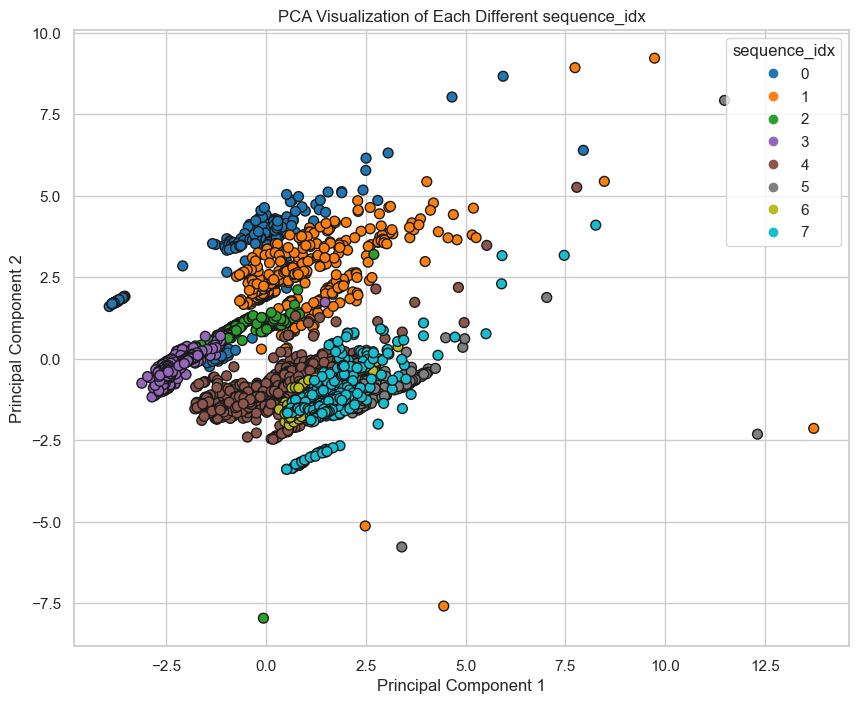

In [22]:
from sklearn.preprocessing import StandardScaler

#Select the data types float64 and int64 and standardize them
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
X = df[numerical_columns]
X_standardized = StandardScaler().fit_transform(X)

#PCA (2-D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_standardized)

#Plotting
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['sequence_idx'], cmap='tab10', edgecolor='k', s=50)
plt.title('PCA Visualization of Each Different sequence_idx')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(*scatter.legend_elements(), title='sequence_idx')
plt.show()


# Exercise 2 Data cleaning and preprocessing

## Task 1: Normalize the dataset.

Define your strategy to normalize the dataset and implement the data. Please pay attention to the difference between fit_transform(), fit(), and transform().

### Theory
Normalization is the process of scaling and centering the features of a dataset, typically to bring them to a similar scale. 
The difference between fit_transform(), fit(), and transform() lies in their functionalities:

fit(): Computes the necessary parameters (e.g., mean and standard deviation) needed to perform the transformation but does not apply the transformation. It is used to compute the normalization parameters on the training data.

transform(): Applies the transformation to the data based on the parameters computed by fit(). It is used to transform the training data and any new, unseen data in the future.

fit_transform(): Combines the fit() and transform() steps into a single operation. It computes the parameters and applies the transformation simultaneously. It is commonly used for the initial normalization of the training data.

An explanatory example follows of how normalization with StandardScaler is constructed.

In [ ]:
from sklearn.preprocessing import StandardScaler


# Extract numerical features
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
X = df[numerical_columns]

scaler = StandardScaler()

# Fit and transform the data
X_normalized = scaler.fit_transform(X)

#The scaler is now fitted

## Task 2: Define a strategy to remove outliers.

Explain how you remove the outliers and implement your approach here.

# Answer

1) First of all, a threshold criterion should be applied in order to identify the outliers. Standard deviation or IQR could be used.

2) A method upon which the removal of the outliers will happen should be determined. Z-score could be of some use, due to it being based on identifying values beyond the afforementioned threshold. Another approach that could be of use is the visualization through distribution. When we try to evaluate the values feasibility in normal operations, a normal (Gaussian) distribution could provide us with useful insight as to where a good threshold should be set.

3) Values due to errors or anomalies can be removed with pandas library ( remove_outliers_"chosen_method")

4) Before removal and threshold determination, some values that seem to be anomalies or errors should be reconsidered before being removed because of their feasible nature in the dataset

### Outlier removal with Z-score method 

A more thorough and dataset based approach follows on Exercise 4.

In [ ]:
import pandas as pd
from scipy import stats


def remove_outliers_zscore(df, columns, threshold=3):
    for column in columns:
        z_scores = stats.zscore(df[column])
        abs_z_scores = abs(z_scores)
        
        # Identify outliers based on the threshold
        outliers = (abs_z_scores > threshold)
        
        # Remove outliers
        df = df[~outliers]
    
    return df

# List of numerical columns to consider
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Remove outliers using the z-score method
df_no_outliers_zscore = remove_outliers_zscore(df, numerical_columns)


## Task 3: Define a strategy to smooth the data.

Explain how do you smooth the data and implement your approach here.

### Answer
Smoothing data is a technique used to reduce noise or fluctuations in a dataset, making underlying patterns more discernible. There are various methods to smooth data, and the choice often depends on the nature of the data and the goals of analysis. One common smoothing technique is moving averages (simple, weighted or exponential) or the simple exponential smoothing (SES) method.  

A general strategy for data smoothing includes:
1) Kernel or window adjustment to determine the adjacency of data points for smoothing
2) Choose a smoothing function 
3) Fitting of the function 
4) Edge effects handling in order to determine how the data beyond the window will be processed
5) Parameter adjustment

### Data smoothing with moving average: a general example

In [ ]:
import numpy as np

def smooth_data_sma(data, window_size=3):
    """
    Smooth data using a simple moving average.

    Parameters:
    - data: Input data as a 1D array or list.
    - window_size: Size of the moving window for smoothing.

    Returns:
    - Smoothed data as a NumPy array.
    """
    smoothed_data = np.convolve(data, np.ones(window_size)/window_size, mode='valid')
    return smoothed_data

# Example Usage:
original_data = np.array([1, 2, 3, 4, 5, 4, 3, 2, 1])
window_size = 3
smoothed_result = smooth_data(original_data, window_size)
print("Original Data:", original_data)
print("Smoothed Data:", smoothed_result)

# Exercise 3 Feature engineering

## Task 1: Use violin plot to explore the significance of each feature.

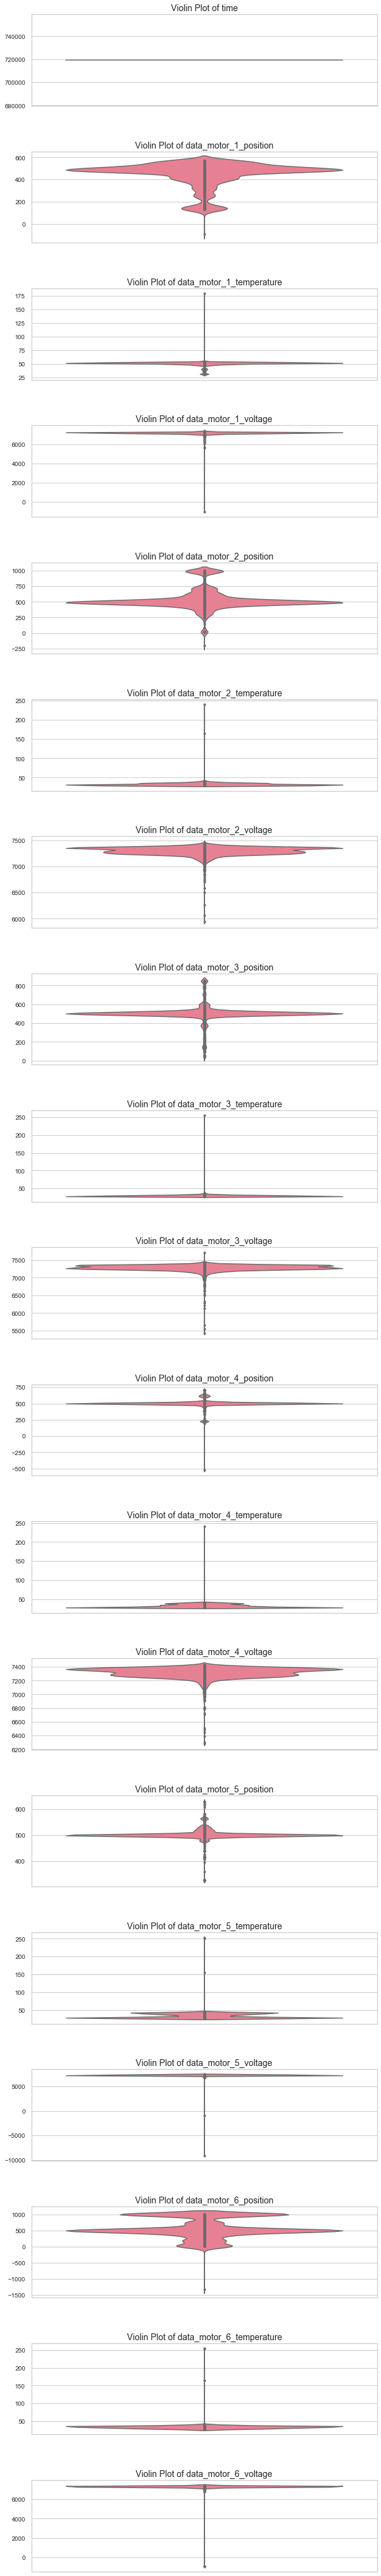

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd


# Convert datetime string to datetime objects
df['time'] = pd.to_datetime(df['time'])

# Convert datetime objects to numeric values, because I faced problems with certains date strings compatibility with a violin plot
df['time'] = mdates.date2num(df['time'])

# Exclude specific columns
exclude_columns = ['sequence_idx', 'label']
filtered_df = df.drop(columns=exclude_columns, errors='ignore')

# Brighter color palette
bright_palette = sns.color_palette("husl", len(filtered_df.columns))

# Set the style for seaborn
sns.set(style="whitegrid", palette=bright_palette)

# Set up subplots
num_plots = len(filtered_df.columns)
fig, axes = plt.subplots(nrows=num_plots, ncols=1, figsize=(10, 4 * num_plots))
fig.subplots_adjust(hspace=0.5)

# Plot violin plots for each feature
for i, column in enumerate(filtered_df.columns):
    sns.violinplot(filtered_df[column], ax=axes[i], width=0.8, inner='point', alpha=0.7)
    axes[i].set_title(f'Violin Plot of {column}', fontsize=14)
    axes[i].set_xlabel('')
    axes[i].xaxis.set_major_locator(plt.MaxNLocator(nbins=5))
    axes[i].tick_params(axis='both', labelsize=10)

# Display the plots
plt.show()

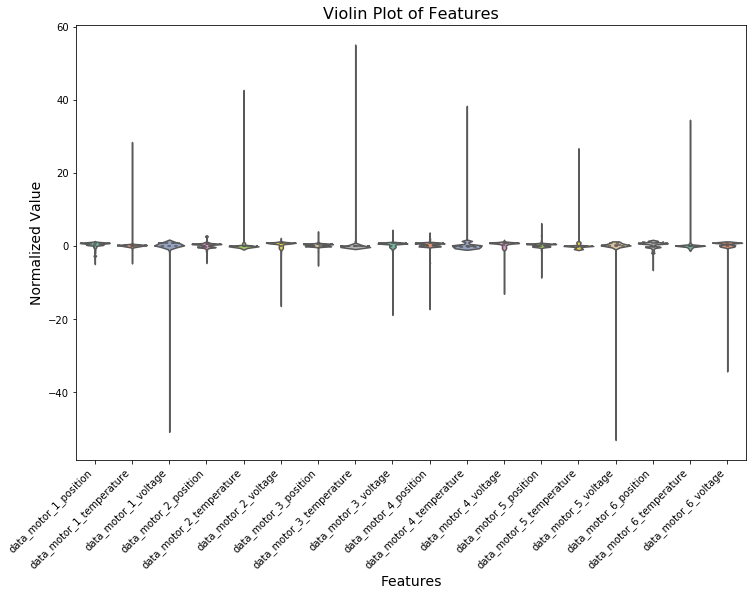

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler


# Standardize the features in X
scaler_standard = StandardScaler()
X_standardized = pd.DataFrame(scaler_standard.fit_transform(X), columns=X.columns)

# Normalize the features in X
scaler_normalize = MinMaxScaler()
X_normalized = pd.DataFrame(scaler_normalize.fit_transform(X), columns=X.columns)

# Combine the standardized and normalized features with the target variable y
data_standardized = pd.concat([y, X_standardized.iloc[:, 0:10]], axis=1)
data_normalized = pd.concat([y, X_normalized.iloc[:, 0:10]], axis=1)

# Combine the standardized and normalized features
X_combined = pd.concat([X_standardized, X_normalized], ignore_index=True)

# Melt the DataFrame for visualization
data_combined_melted = pd.melt(X_combined, var_name="features", value_name='value')


# Plot for normalized and standardized features
plt.figure(figsize=(12, 8))
sns.violinplot(x="features", y="value", data=data_combined_melted, split=True, inner="quart", scale="count", palette="Set2")
plt.xticks(rotation=45, ha='right')  # Adjust rotation for better readability
plt.title('Violin Plot of Features', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Normalized Value', fontsize=14)
plt.show()



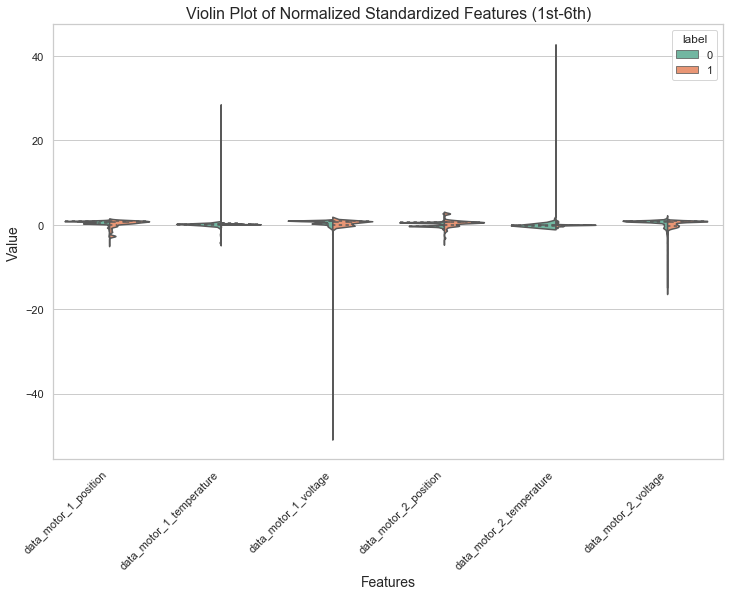

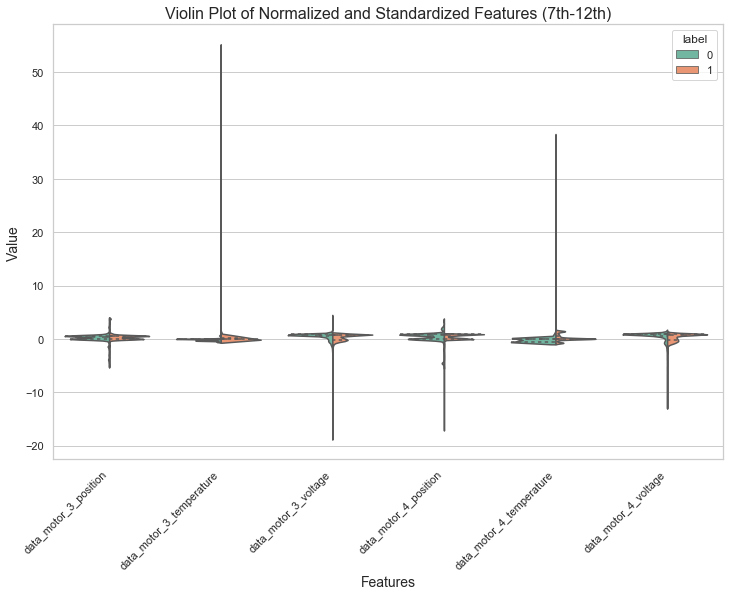

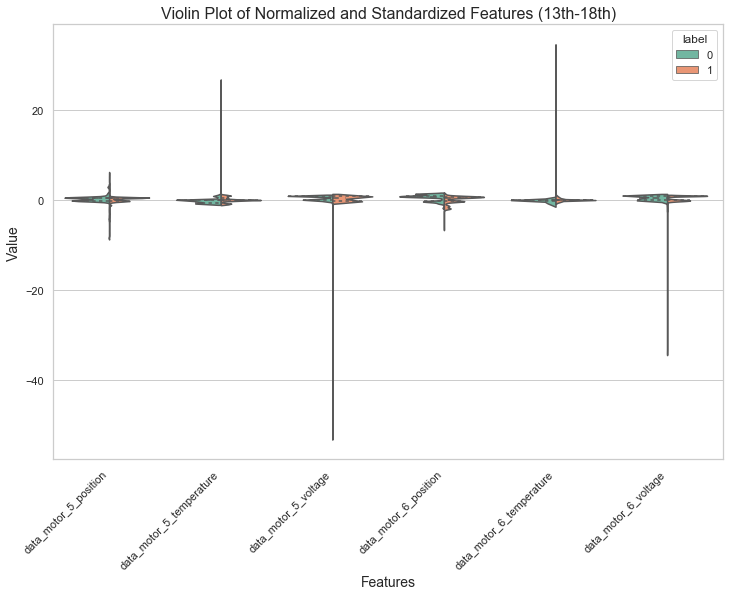

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Standardize the features in X
scaler_standard = StandardScaler()
X_standardized = pd.DataFrame(scaler_standard.fit_transform(X), columns=X.columns)

# Normalize the features in X
scaler_normalize = MinMaxScaler()
X_normalized = pd.DataFrame(scaler_normalize.fit_transform(X), columns=X.columns)

# Combine the standardized and normalized features with the target variable y
data_standardized = pd.concat([y, X_standardized], axis=1)
data_normalized = pd.concat([y, X_normalized], axis=1)

# Melt the DataFrame for visualization
data_standardized_melted = pd.melt(data_standardized, id_vars="label", var_name="features", value_name='value')
data_normalized_melted = pd.melt(data_normalized, id_vars="label", var_name="features", value_name='value')


# Concatenate the melted DataFrames
data_combined_melted = pd.concat([data_standardized_melted, data_normalized_melted], ignore_index=True)

# Plot for features (1st-6th)
plt.figure(figsize=(12, 8))
sns.violinplot(x="features", y="value", hue="label", data=data_combined_melted[data_combined_melted['features'].isin(X.columns[:6])], split=True, inner="quart", scale="count", palette="Set2")
plt.xticks(rotation=45, ha='right')  # Adjust rotation for better readability
plt.title('Violin Plot of Normalized Standardized Features (1st-6th)', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.show()

# Plot for features (7th-12th)
plt.figure(figsize=(12, 8))
sns.violinplot(x="features", y="value", hue="label", data=data_combined_melted[data_combined_melted['features'].isin(X.columns[6:12])], split=True, inner="quart", scale="count", palette="Set2")
plt.xticks(rotation=45, ha='right')  # Adjust rotation for better readability
plt.title('Violin Plot of Normalized and Standardized Features (7th-12th)', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.show()

# Plot for features (13th-18th)
plt.figure(figsize=(12, 8))
sns.violinplot(x="features", y="value", hue="label", data=data_combined_melted[data_combined_melted['features'].isin(X.columns[12:])], split=True, inner="quart", scale="count", palette="Set2")
plt.xticks(rotation=45, ha='right')  # Adjust rotation for better readability
plt.title('Violin Plot of Normalized and Standardized Features (13th-18th)', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.show()



## Task 2: Use correlation coefficient matrix to explore the correlation among the features.

### Correlation Matrix (Pearson's coefficient)

C:\Users\User\AppData\Local\Temp\ipykernel_8056\2604974098.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


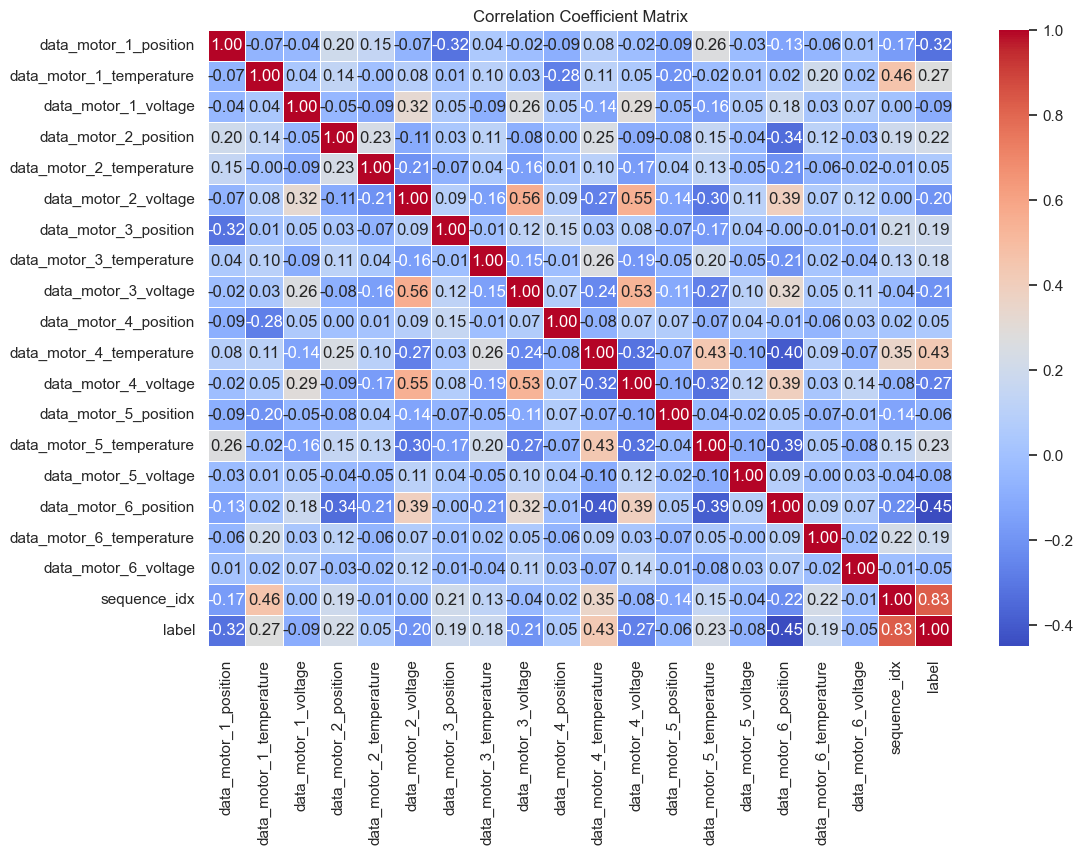

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix
correlation_matrix = df.corr()

# Plot features
plt.figure(figsize=(12, 8))

# Heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Plotting
plt.title('Correlation Coefficient Matrix')
plt.show()


### Triangle Correlation Heatmap

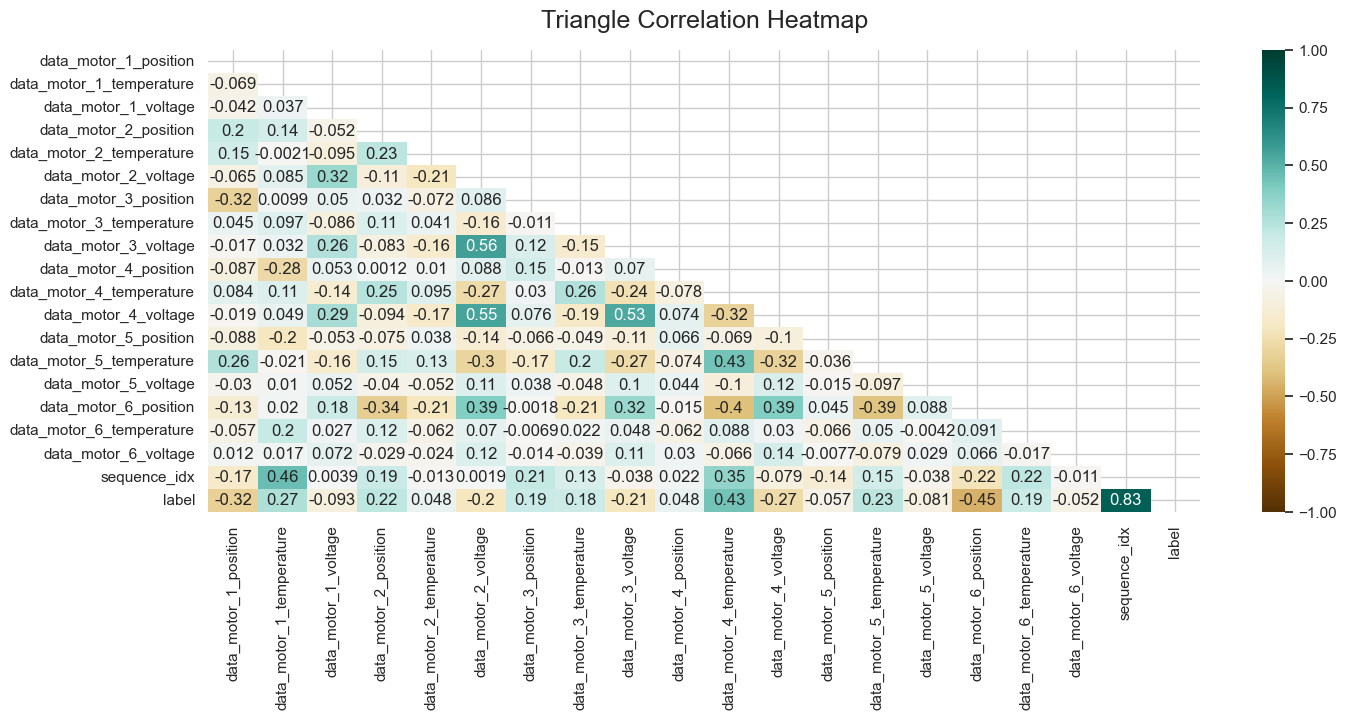

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

mask = np.triu(np.ones_like(X.corr(), dtype=bool))

plt.figure(figsize=(16, 6))

heatmap = sns.heatmap(X.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')

heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize': 18}, pad=16)

# Plot
plt.show()

## Conclusion of feature engineering

**Write your conclusion of feature engineering here.** For example, which features are most relevant? Which features are not relevant? Which features are redundant? Which features are irrelevant? Eventually, what are your decisions regarding which features to be used?




## Conclusion of feature engineering
Based on the visualization of the violin plots and the correlation matrix values, it is notable that the highest correlation is observed is between the voltage between motor 2,3 with a value of 0.56, indicating strong correlation between the two features, whereas the position of both motors 3,6 do not seem to share a correlation link, striking a complete uncorellatedness (0.00).

Temperature of motor 3 and voltage of motor 5 note the highest discrepancies between the other features with highest nominal values observed as data points, that could be also an outcome of error proneness of the data collection. Thus, a more thorough investigation on data cleaning should be processed and would provide us with useful insights.

In general, voltage values seem to be correlated between each motor and should probably be regarded as an important feature for detection and diagnosis of our model.

# Exercise 4 Implement the statistical testing approach for fault detection

In this exercise, we interpret the statistical testing approach for fault detection. The basic idea of statistical testing approach is that we fit a multi-dimensitional distribution to the observation data under normal working condition. Then, when a new data point arrives, we design a hypothesis test to see whether the new data point is consistent with the distribution. If the new data point is consistent with the distribution, we can conclude that the fault is not due to the faulty component.

The benefit of this approach is that, to design the detection algrothim, we do not need failed data. Also, the computational time is short as all we need is just to compute the pdf and compare it to a threshold.

In this exercise, you need to:
- Seperate the original dataset into training and testing datasets.
- Fit a multi-dimensitional distribution to the training dataset.
- Design a fault detection algorithm based on the fitted distribution.

The following block defines a few functions that you can use.

In [25]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import multivariate_normal


def estimateGaussian(X):
    '''Given X, this function estimates the parameter of a multivariate Gaussian distribution.'''
    mu = np.mean(X, axis=0)
    sigma2 = np.var(X, axis=0)
    return mu, sigma2


def classify(X, distribution, log_epsilon=-50):
    '''Given X, this function classifies each sample in X based on the multivariate Gaussian distribution. 
       The decision rule is: if the log pdf is less than log_epsilon, we predict 1, as the sample is unlikely to be from the distribution, which represents normal operation.
    '''
    p = distribution.logpdf(X)
    predictions = (p < log_epsilon).astype(int)
    
    return predictions

Please design your algorithm below:

In [51]:
pip install --upgrade scikit-learn

  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/4e/ba/ce9bd1cd4953336a0e213b29cb80bb11816f2a93de8c99f88ef0b446ad0c/scikit_learn-1.3.2-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/9.2 MB ? eta -:--:--
   - -------------------------------------- 0.4/9.2 MB 8.3 MB/s eta 0:00:02
   ---- ----------------------------------- 0.9/9.2 MB 9.8 MB/s eta 0:00:01
   ------ --------------------------------- 1.5/9.2 MB 10.4 MB/s eta 0:00:01
   --------- ------------------------------ 2.2/9.2 MB 11.5 MB/s eta 0:00:01
   -------------- ------------------------- 3.3/9.2 MB 14.0 MB/s eta 0:00:01
   ------------------- -------------------- 4.5/9.2 MB 16.0 MB/s eta 0:00:01
   ------------------------- -------------- 5.8/9.2 MB 17.7 MB/s eta 0:00:01
   ------------------------------- -------- 7.1/9.2 MB 19.0 MB/s eta 0:00:01
   ------------------------------------- -- 8.6/9.2 MB 20.4 MB/s eta 0:00:01
   -------------------

# Cross validation, Hyperparameter Tuning, Model fitting, ROC Curve, Precision-Recall Curve and Confusion Matrix

C:\Users\User\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1169, in fit
    solver = _che

Best Parameters: {'C': 0.021544346900318832, 'penalty': 'l2'}
Accuracy: 0.9055555555555556
Confusion Matrix:
[[94 12]
 [ 5 69]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       106
           1       0.85      0.93      0.89        74

    accuracy                           0.91       180
   macro avg       0.90      0.91      0.90       180
weighted avg       0.91      0.91      0.91       180

ROC AUC Score: 0.9096124426313106


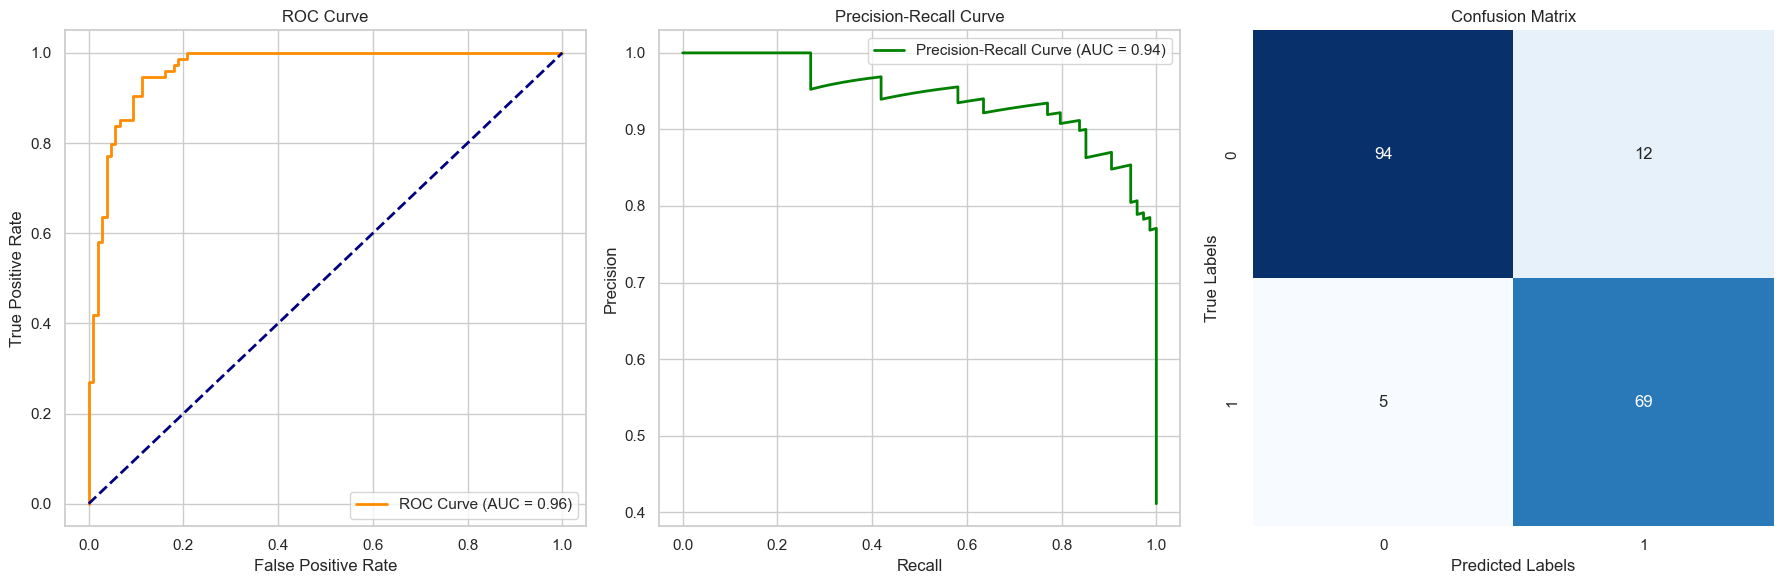

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# Train-test-split algorithm
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

# Logistic regression model
logreg = LogisticRegression()

# Hyperparameters for GridSearchCV
param_grid = {
    'C': np.logspace(-3, 1, 10),  # Regularization parameter
    'penalty': ['l1', 'l2']       # Penalty term
}

# GridSearchCV with accuracy as a metrics criterion 
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# GridSearchCV hyperparameter tuning 
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")


# Prediction with GridSearchCV
y_pred = grid_search.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{classification_rep}")
print(f"ROC AUC Score: {roc_auc}")

# Subplots of ROC curve, Precision-Recall curve and Confusion Matrix
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, grid_search.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_title('ROC Curve')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend(loc="lower right")

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, grid_search.predict_proba(X_test)[:, 1])
pr_auc = auc(recall, precision)
ax2.plot(recall, precision, color='green', lw=2, label=f'Precision-Recall Curve (AUC = {pr_auc:.2f})')
ax2.set_title('Precision-Recall Curve')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.legend(loc="upper right")

# Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax3)
ax3.set_title('Confusion Matrix')
ax3.set_xlabel('Predicted Labels')
ax3.set_ylabel('True Labels')

plt.tight_layout()
plt.show()


In [36]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, grid_search.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Sensitivity and Specificity for each threshold
sensitivity = tpr
specificity = 1 - fpr
# G-Mean 
g_mean = np.sqrt(sensitivity * specificity)

# Threshold
best_threshold_index = np.argmax(g_mean)
best_threshold = thresholds[best_threshold_index]

print(f"Best Threshold (G-Mean): {best_threshold}")


Best Threshold (G-Mean): 0.4881204421242418


In [28]:
from sklearn.metrics import precision_score, recall_score, f1_score

# precision, recall, and F1 score for the 1 class
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Precision: 0.8028169014084507
Recall: 0.7702702702702703
F1 Score: 0.7862068965517242


In [38]:
from scipy.stats import multivariate_normal
from sklearn.metrics import accuracy_score

mu = np.mean(X_train, axis=0)
sigma2 = np.cov(X_train, rowvar=False)

# Multivariate Gaussian distribution
distribution = multivariate_normal(mean=mu, cov=np.diag(sigma2))

# Best threshold for anomaly detection
threshold = 0.4881204421242418 

# Prediction
y_pred_prob = distribution.pdf(X_test)
y_pred = (y_pred_prob < threshold).astype(int)

# Accuracy of the prediction.
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.4111111111111111


**Discussions:**
- Can you please try to improve the performance of this approach?
    - For example, by normalizating the data?
    - By smoothing the data?
    - By reducing feature number?
    - etc.
- The parameter log_epsilon defines the threshold we use for making classification. What happens if you change it?
- Could you discuss how we should get the best value for this parameter?